<a href="https://colab.research.google.com/github/ro200227/Euro_CurrencyClassification/blob/main/euro_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import zipfile

zip_path = "/content/drive/MyDrive/Euro_Classification/euro_dataset.zip"
extract_path = "/content/euro_classification"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os


# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset from extracted folder
data_path = "/content/euro_classification"
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

#Split into train/val sets (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print("Dataset ready.")
print("Classes:", full_dataset.classes)
print(f"Total Images: {len(full_dataset)}")


Dataset ready.
Classes: ['euro banknote front', 'not_euro']
Total Images: 129


🪙 Euro Images:


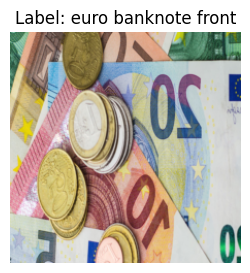

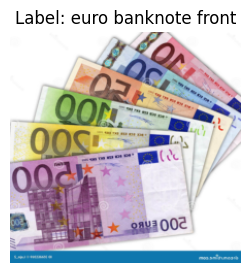

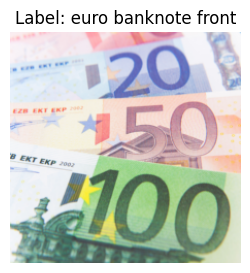

💵 Not-Euro Images:


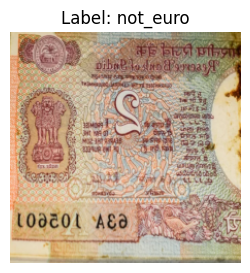

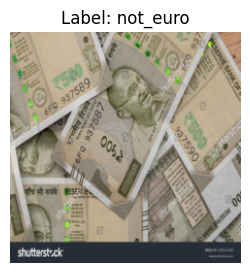

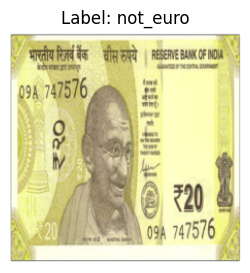

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display image
def imshow(img, label):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Label: {full_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

# Show 3 Euro images (label = 0)
count = 0
print("🪙 Euro Images:")
for i in range(len(full_dataset)):
    img, label = full_dataset[i]
    if label == 0:
        imshow(img, label)
        count += 1
        if count == 3:
            break

# Show 3 Not-Euro images (label = 1)
count = 0
print("💵 Not-Euro Images:")
for i in range(len(full_dataset)):
    img, label = full_dataset[i]
    if label == 1:
        imshow(img, label)
        count += 1
        if count == 3:
            break


In [11]:
from torchvision import models

# Load the ResNet18 model pretrained on ImageNet
model = models.resnet18(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.7MB/s]


In [12]:
# Freeze all parameters so their weights don't change during training
for param in model.parameters():
    param.requires_grad = False


In [13]:
import torch.nn as nn

# Get the number of input features to the final layer
num_ftrs = model.fc.in_features

# Replace the final layer with a new one for 2 output classes
model.fc = nn.Linear(num_ftrs, 2)


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function: CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam, only train the final layer (model.fc)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Set up DataLoaders (we already split full_dataset before)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training loop for 5 epochs
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/5: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Epoch 1 Loss: 0.8646


Epoch 2/5: 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


Epoch 2 Loss: 0.6811


Epoch 3/5: 100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Epoch 3 Loss: 0.6177


Epoch 4/5: 100%|██████████| 7/7 [00:13<00:00,  2.00s/it]


Epoch 4 Loss: 0.5966


Epoch 5/5: 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

Epoch 5 Loss: 0.5355


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set model to evaluation mode
model.eval()

# Lists to store true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate accuracy
accuracy = 100 * np.mean(np.array(y_true) == np.array(y_pred))
print(f"Validation Accuracy: {accuracy:.2f}%")

# Classification report
print("\/n Classification Report:")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

# Confusion matrix
print("\n Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Validation Accuracy: 69.23%
\/n Classification Report:
                     precision    recall  f1-score   support

euro banknote front       0.62      0.83      0.71        12
           not_euro       0.80      0.57      0.67        14

           accuracy                           0.69        26
          macro avg       0.71      0.70      0.69        26
       weighted avg       0.72      0.69      0.69        26


 Confusion Matrix:
[[10  2]
 [ 6  8]]


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Stronger Image Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#  Reload dataset with new transforms
data_path = "/content/euro_classification"
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

#  DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#  Load pretrained ResNet18
model = models.resnet18(pretrained=True)

#  Unfreeze the last 2 layers and final fc layer
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

#  Replace the final classification layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#  Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)

# Train for more epochs
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {running_loss / len(train_loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 7/7 [00:26<00:00,  3.79s/it]


Epoch 1 Loss: 0.6666


Epoch 2/10: 100%|██████████| 7/7 [00:18<00:00,  2.65s/it]


Epoch 2 Loss: 0.2337


Epoch 3/10: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]


Epoch 3 Loss: 0.0982


Epoch 4/10: 100%|██████████| 7/7 [00:18<00:00,  2.70s/it]


Epoch 4 Loss: 0.0664


Epoch 5/10: 100%|██████████| 7/7 [00:18<00:00,  2.69s/it]


Epoch 5 Loss: 0.1041


Epoch 6/10: 100%|██████████| 7/7 [00:20<00:00,  2.95s/it]


Epoch 6 Loss: 0.0489


Epoch 7/10: 100%|██████████| 7/7 [00:23<00:00,  3.39s/it]


Epoch 7 Loss: 0.3292


Epoch 8/10: 100%|██████████| 7/7 [00:21<00:00,  3.03s/it]


Epoch 8 Loss: 0.1131


Epoch 9/10: 100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


Epoch 9 Loss: 0.1789


Epoch 10/10: 100%|██████████| 7/7 [00:20<00:00,  2.86s/it]

Epoch 10 Loss: 0.0504


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set model to evaluation mode
model.eval()

# Collect predictions
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Accuracy
accuracy = 100 * np.mean(np.array(y_true) == np.array(y_pred))
print(f"🎯 Improved Validation Accuracy: {accuracy:.2f}%")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

# Confusion Matrix
print("\n🔁 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


🎯 Improved Validation Accuracy: 92.31%

📋 Classification Report:
                     precision    recall  f1-score   support

euro banknote front       1.00      0.87      0.93        15
           not_euro       0.85      1.00      0.92        11

           accuracy                           0.92        26
          macro avg       0.92      0.93      0.92        26
       weighted avg       0.93      0.92      0.92        26


🔁 Confusion Matrix:
[[13  2]
 [ 0 11]]


In [22]:
# Saving trained model weights
torch.save(model.state_dict(), "euro_classifier_resnet18.pth")
print("✅ Model saved as euro_classifier_resnet18.pth")


✅ Model saved as euro_classifier_resnet18.pth


In [24]:
# Save to Google Drive
!cp euro_classifier_resnet18.pth /content/drive/MyDrive/Euro_Classification/
print("✅ Model copied to Google Drive /Euro_Classification/")


✅ Model copied to Google Drive /Euro_Classification/


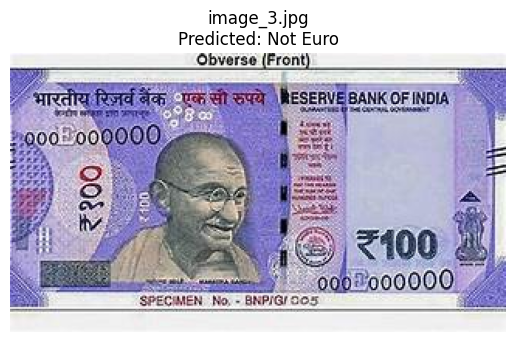

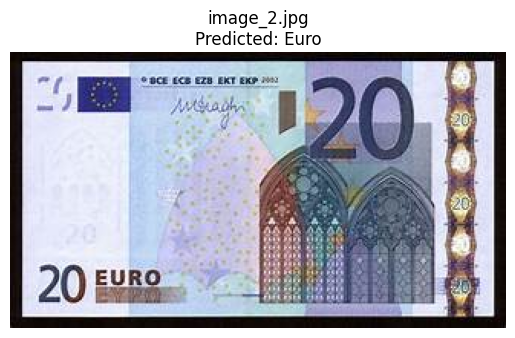

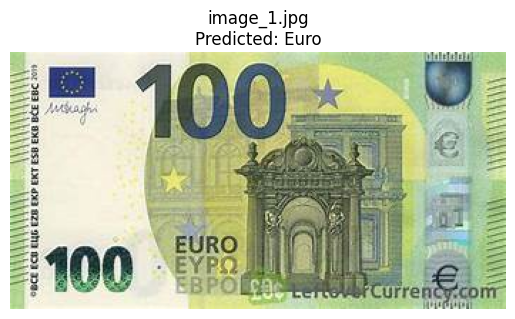

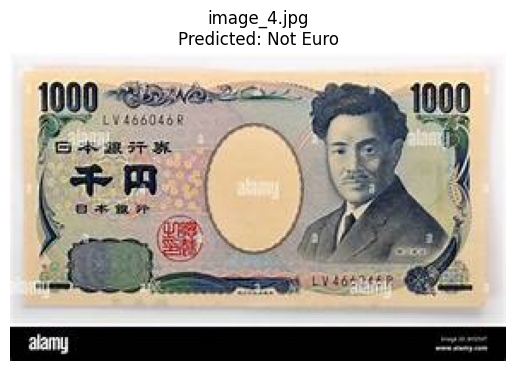

In [28]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 🔁 Same transform as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Folder containing test images
test_folder = "/content/drive/MyDrive/Euro_Classification/test"

# Clean label mapping
label_map = {
    "euro banknote front": "Euro",
    "not_euro": "Not Euro"
}

# Loop through and display predictions with images
model.eval()
for filename in os.listdir(test_folder):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(test_folder, filename)

        # Load and preprocess
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            raw_class = full_dataset.classes[pred.item()]
            predicted_class = label_map[raw_class]

        # Show image with prediction
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{filename}\nPredicted: {predicted_class}", fontsize=12)
        plt.show()
